In [111]:
import pandas as pd

covid_data = pd.read_csv('data/covid_data.csv')

vaccinations_data = pd.read_csv('data/country_vaccinations.csv')
vaccinations_data = vaccinations_data[
    ['country', 'date', 'total_vaccinations', 
     'people_vaccinated', 'people_vaccinated_per_hundred',
     'people_fully_vaccinated', 'people_fully_vaccinated_per_hundred',
     'daily_vaccinations', 'vaccines']
]

vaccinations_data['date'] = pd.to_datetime(vaccinations_data['date'])

covid_data = covid_data.groupby(['date', 'country'], as_index=False)[['confirmed', 'deaths', 'recovered']].sum()
covid_data['date'] = pd.to_datetime(covid_data['date'])

covid_data['active'] = covid_data['confirmed'] - covid_data['deaths'] - covid_data['recovered']

covid_data = covid_data.sort_values(by=['country', 'date'])

covid_data['daily_confirmed'] = covid_data.groupby('country')['confirmed'].diff()
covid_data['daily_deaths'] = covid_data.groupby('country')['deaths'].diff()
covid_data['daily_recovered'] = covid_data.groupby('country')['recovered'].diff()


covid_df = covid_data.merge(vaccinations_data, how='left', on=['date', 'country'])

covid_df['death_rate'] = covid_df['deaths'] / covid_df['confirmed'] * 100
covid_df['recover_rate'] = covid_df['recovered'] / covid_df['confirmed'] * 100


covid_df[covid_df['country'] == 'Russia']['recover_rate'].mean()



67.06273489477655

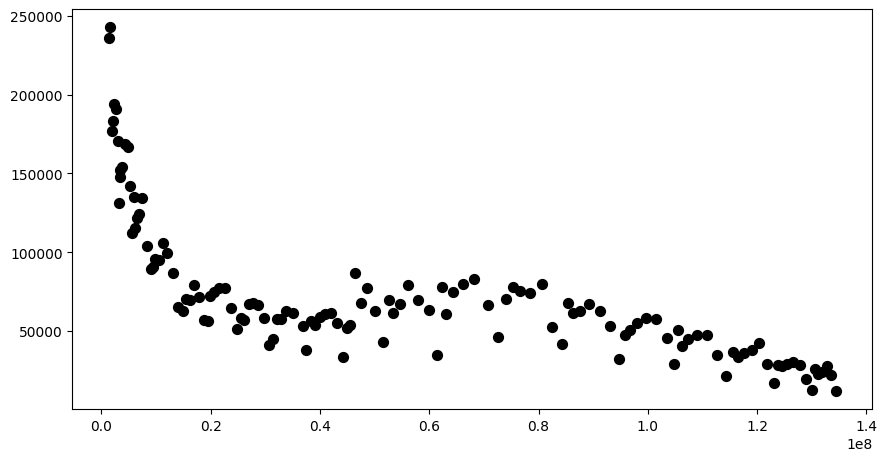

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('default')

us_data = covid_df[covid_df['country'] == 'United States']

fig = plt.figure(figsize=(8, 4))
axes = fig.add_axes([0, 0, 1, 1])

axes.scatter(
    x = us_data['people_fully_vaccinated'], 
    y = us_data['daily_confirmed'],
    s = 50,
    c = 'black'
);

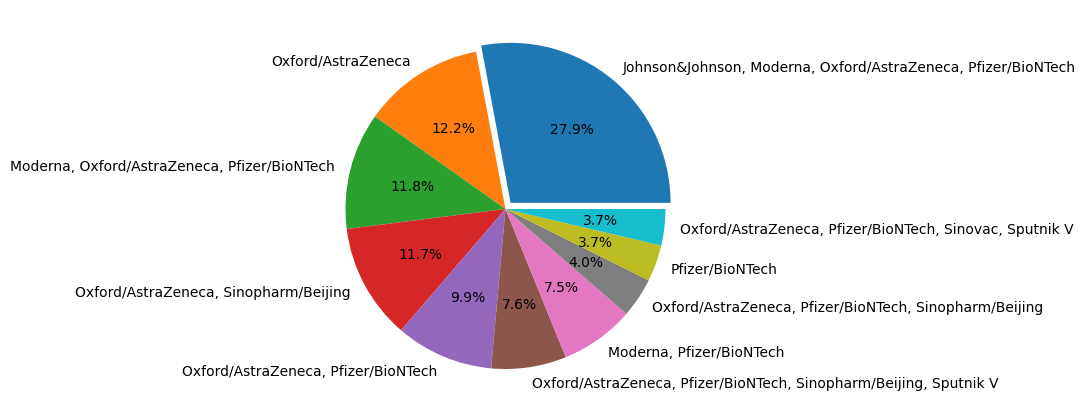

In [42]:
vaccine_combinations = covid_df['vaccines'].value_counts()[:10]

fig = plt.figure(figsize=(8, 4))
axes = fig.add_axes([0, 0, 1, 1])

axes.pie(
    vaccine_combinations,
    labels = vaccine_combinations.index,
    autopct='%.1f%%',
    explode = [0.05, 0, 0, 0, 0, 0, 0, 0, 0, 0]
);


In [74]:
import seaborn as sns

countries = ['Russia', 'Australia', 'Germany', 'Canada', 'United Kingdom']
croped_covid_df = covid_df[covid_df['country'].isin(countries)]

populations = pd.DataFrame([
    ['Canada', 37664517],
    ['Germany', 83721496],
    ['Russia', 145975300],
    ['Australia', 25726900],
    ['United Kingdom', 67802690]
    ],
    columns=['country', 'population']
)
croped_covid_df = croped_covid_df.merge(populations, on=['country'])
croped_covid_df['daily_confirmed_per_hundred'] = croped_covid_df['daily_confirmed'] / croped_covid_df['population'] * 100
croped_covid_df.head()

,date,country,confirmed,deaths,recovered,active,daily_confirmed,daily_deaths,daily_recovered,total_vaccinations,people_vaccinated,people_vaccinated_per_hundred,people_fully_vaccinated,people_fully_vaccinated_per_hundred,daily_vaccinations,vaccines,death_rate,recover_rate,population,daily_confirmed_per_hundred
0,2020-01-23,Australia,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25726900,NaN
1,2020-01-25,Australia,4.0,0.0,0.0,4.0,4.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,25726900,0.000016
2,2020-01-26,Australia,4.0,0.0,0.0,4.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,25726900,0.000000
3,2020-01-27,Australia,5.0,0.0,0.0,5.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,25726900,0.000004
4,2020-01-28,Australia,5.0,0.0,0.0,5.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,25726900,0.000000


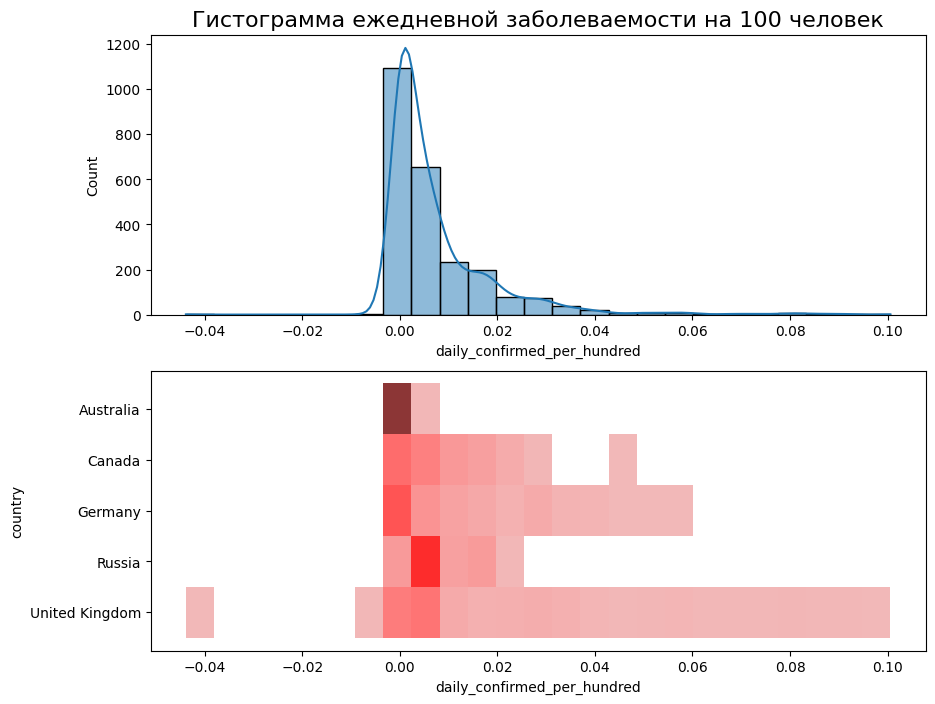

In [81]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=[10, 8])

sns.histplot(
    data=croped_covid_df,
    x = 'daily_confirmed_per_hundred',
    bins = 25, 
    ax = axes[0], 
    kde = True, 
);
axes[0].set_title('Гистограмма ежедневной заболеваемости на 100 человек', fontsize=16)

sns.histplot(
    data=croped_covid_df,
    x='daily_confirmed_per_hundred',
    y='country',
    bins=25,
    color='red',
    ax=axes[1]
);




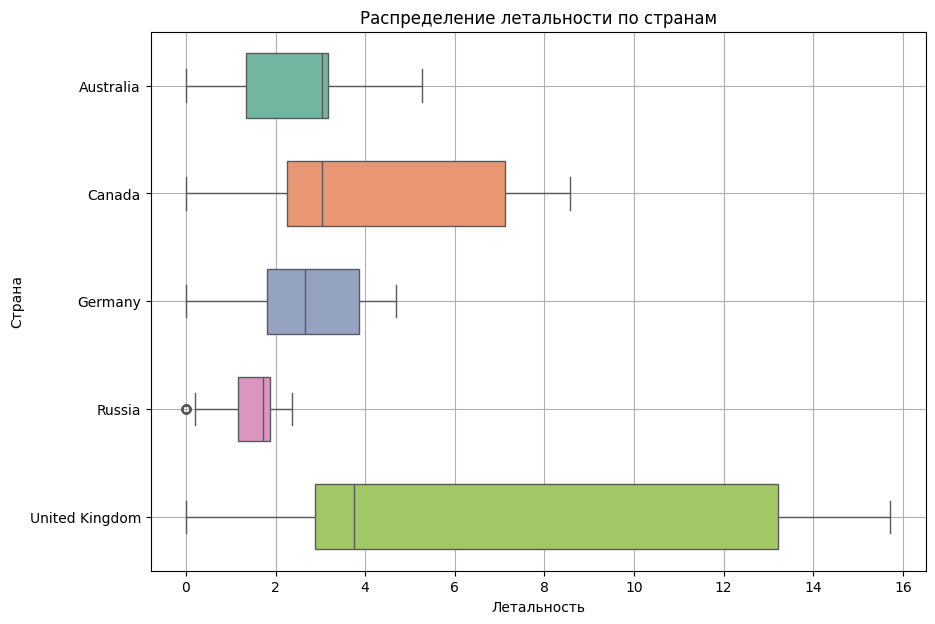

In [96]:
fig = plt.figure(figsize=(10, 7))
boxplot = sns.boxplot(
    data=croped_covid_df,
    y='country',
    x='death_rate',
    hue = 'country',
    orient='h',
    width=0.6, 
    palette='Set2'
);
boxplot.set_title('Распределение летальности по странам');
boxplot.set_xlabel('Летальность');
boxplot.set_ylabel('Страна');
boxplot.grid();

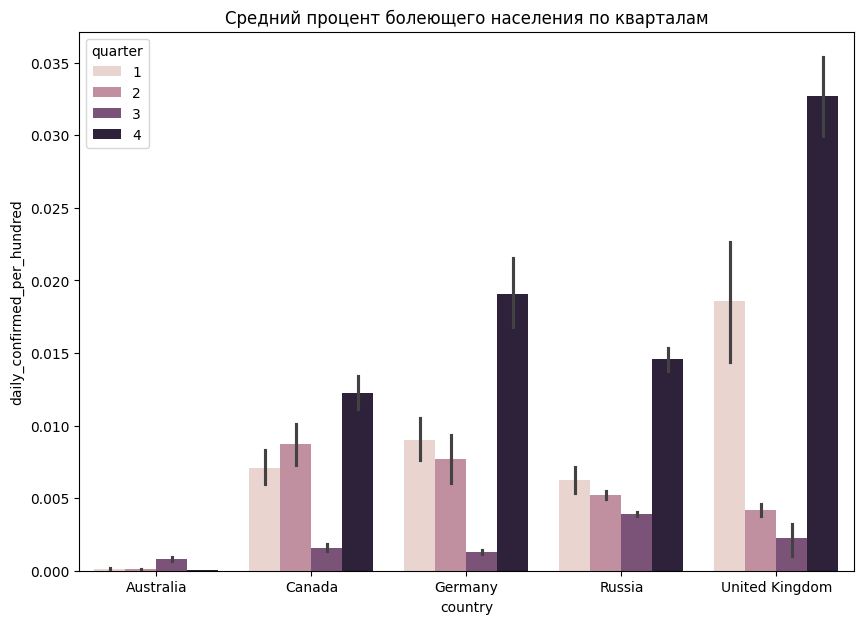

In [103]:
fig = plt.figure(figsize=(10, 7))
croped_covid_df['quarter'] = croped_covid_df['date'].dt.quarter
barplot = sns.barplot(
    data=croped_covid_df,
    x='country',
    y='daily_confirmed_per_hundred',
    hue='quarter'
)
barplot.set_title('Средний процент болеющего населения по кварталам');

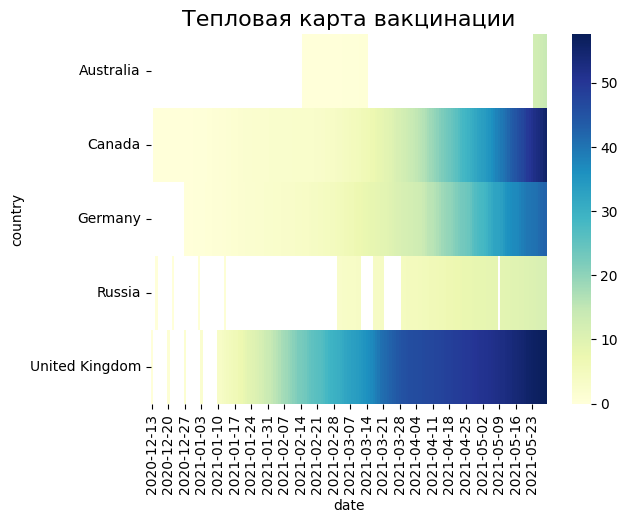

In [104]:
pivot = croped_covid_df.pivot_table(
    values='people_vaccinated_per_hundred',
    columns='date',
    index='country',
)
pivot.columns = pivot.columns.astype('string')

heatmap = sns.heatmap(data=pivot, cmap='YlGnBu')
heatmap.set_title('Тепловая карта вакцинации', fontsize=16);

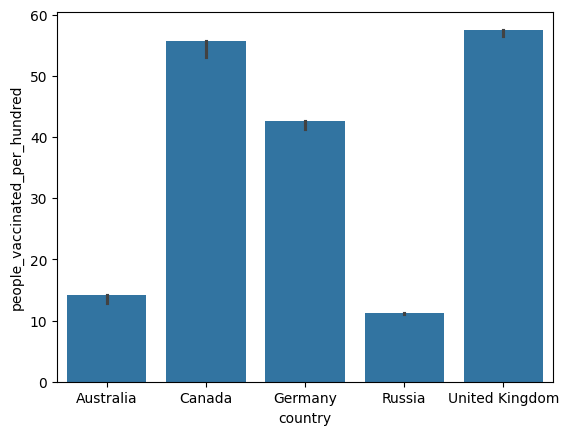

In [107]:
sns.barplot(
    data=croped_covid_df,
    x='country',
    y='people_vaccinated_per_hundred',
    estimator=max
);

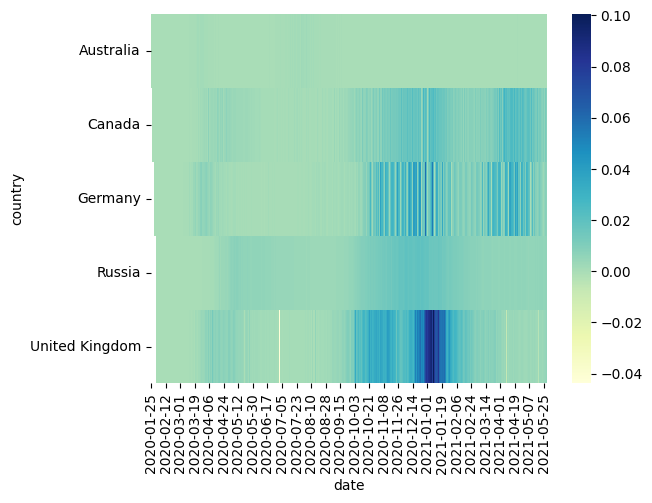

In [120]:
croped_covid_df['confirmed_per_hundred'] = croped_covid_df['daily_confirmed'] / croped_covid_df['population'] * 100

pivot_table = croped_covid_df.pivot_table(
    values='confirmed_per_hundred',
    columns='date',
    index='country'
)
pivot_table.columns = pivot_table.columns.astype('string')

heatmap = sns.heatmap(data=pivot_table, cmap='YlGnBu')

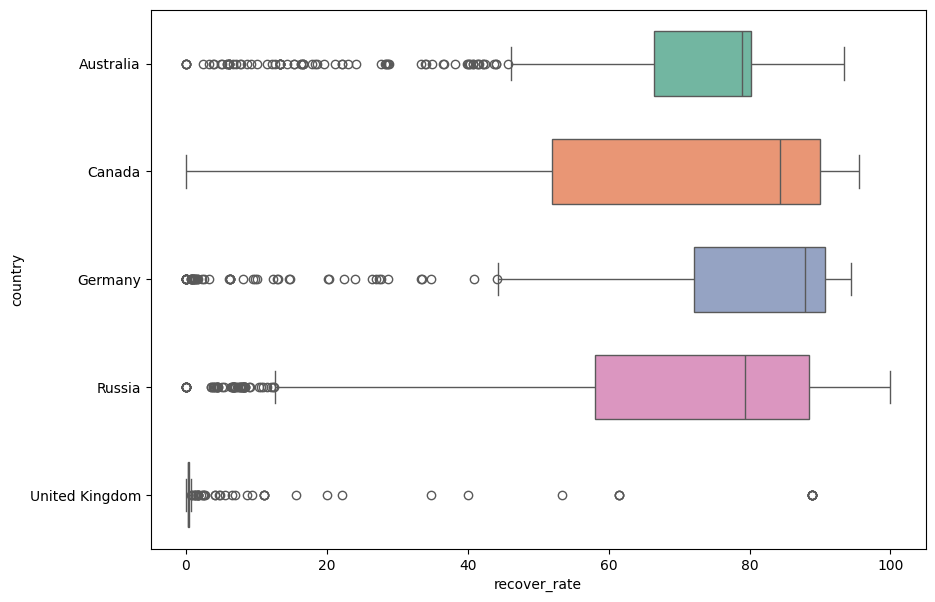

In [124]:
fig = plt.figure(figsize=(10, 7))
boxplot = sns.boxplot(
    data=croped_covid_df,
    y='country',
    x='recover_rate',
    hue = 'country',
    orient='h',
    width=0.7, 
    palette='Set2'
);